In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv('../../Dataset/GVR Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"18,900","18,950","19,000","18,600",2.72M,0.53%
1,06/01/2023,"18,800","18,350","18,900","18,100",4.25M,3.30%
2,05/31/2023,"18,200","18,450","18,450","18,000",3.14M,-1.09%
3,05/30/2023,"18,400","18,300","18,500","17,850",4.58M,1.10%
4,05/29/2023,"18,200","17,200","18,200","17,050",6.08M,5.81%
...,...,...,...,...,...,...,...
1287,03/28/2018,"11,327","10,736","11,622","10,637",139.80K,5.50%
1288,03/27/2018,"10,736","10,637","10,834","10,342",52.20K,5.83%
1289,03/26/2018,"10,145","10,046","10,342","10,046",267.80K,-1.90%
1290,03/23/2018,"10,342","10,440","10,440","9,849",111.80K,-3.67%


In [3]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [4]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,18900.0,18950.0,19000.0,18600.0,2720000.0,0.0053
1,2023-06-01,18800.0,18350.0,18900.0,18100.0,4250000.0,0.0330
2,2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109
3,2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
4,2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
...,...,...,...,...,...,...,...
1287,2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
1288,2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
1289,2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
1290,2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367


In [5]:
df=df.set_index('Date')
df = df.sort_index()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-03-22,10736.0,10834.0,11130.0,10046.0,260800.0,0.0000
2018-03-23,10342.0,10440.0,10440.0,9849.0,111800.0,-0.0367
2018-03-26,10145.0,10046.0,10342.0,10046.0,267800.0,-0.0190
2018-03-27,10736.0,10637.0,10834.0,10342.0,52200.0,0.0583
2018-03-28,11327.0,10736.0,11622.0,10637.0,139800.0,0.0550
...,...,...,...,...,...,...
2023-05-29,18200.0,17200.0,18200.0,17050.0,6080000.0,0.0581
2023-05-30,18400.0,18300.0,18500.0,17850.0,4580000.0,0.0110
2023-05-31,18200.0,18450.0,18450.0,18000.0,3140000.0,-0.0109


In [6]:

import plotly.express as px
fig = px.line(df, x=df.index, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of GVR', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [7]:
# Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
train_size = int((len(df)-1) * 0.7)
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra
X = df[['Price']].iloc[:-1]
Y = df['Price'].shift(-1).iloc[:-1]

X_train, Y_train = X[:train_size], Y[:train_size]
X_test,Y_test = X[train_size:train_size+test_size],Y[train_size:train_size+test_size]
X_val, Y_val = X[train_size+test_size:], Y[train_size+test_size:]
     

In [8]:
# Tạo dictionary params chứa các giá trị của tham số k
params = {'n_neighbors': [i for i in range(1, 30)]}

# Tạo một model KNN mới
knn_model = KNeighborsRegressor()

# Sử dụng GridSearchCV để tìm giá trị tối ưu của k dựa trên tập train
grid_search = GridSearchCV(knn_model, params, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# In giá trị tối ưu của k
print("Giá trị tối ưu của k:", grid_search.best_params_['n_neighbors'])

# Tạo một model KNN mới với k tối ưu được chọn
knn_model = KNeighborsRegressor(n_neighbors= grid_search.best_params_['n_neighbors'])

# Huấn luyện model trên tập train
knn_model.fit(X_train, Y_train)


Giá trị tối ưu của k: 6


KNeighborsRegressor(n_neighbors=6)

In [9]:
print(Y_train)

Date
2018-03-22    10342.0
2018-03-23    10145.0
2018-03-26    10736.0
2018-03-27    11327.0
2018-03-28    11721.0
               ...   
2021-11-02    38277.0
2021-11-03    38910.0
2021-11-04    39056.0
2021-11-05    39641.0
2021-11-08    39543.0
Name: Price, Length: 903, dtype: float64


In [10]:
pred_dates=Y_test.index
last_price=Y_train.iloc[-1]
Y_pred=Y_test.copy()
for date in pred_dates:
  pred = knn_model.predict([[last_price]])
  if len(pred) != 1:
    print("Error: Invalid prediction shape.")
    break
  Y_pred.loc[date]=pred[0] 
  last_price=pred[0]     


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [11]:
print(Y_pred)

Date
2021-11-09    38918.166667
2021-11-10    38837.000000
2021-11-11    38617.833333
2021-11-12    38723.500000
2021-11-15    38731.500000
                  ...     
2022-11-14    38731.500000
2022-11-15    38731.500000
2022-11-16    38731.500000
2022-11-17    38731.500000
2022-11-18    38731.500000
Name: Price, Length: 258, dtype: float64


In [12]:
pred_dates=Y_val.index
last_price=Y_test.iloc[-1]
Y_pred_val=Y_val.copy()
for date in pred_dates:
  pred = knn_model.predict([[last_price]])
  if len(pred) != 1:
    print("Error: Invalid prediction shape.")
    break
  Y_pred_val.loc[date]=pred[0] 
  last_price=pred[0]    
print(Y_pred_val)

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



Date
2022-11-21    13064.666667
2022-11-22    12990.333333
2022-11-23    13064.666667
2022-11-24    12990.333333
2022-11-25    13064.666667
                  ...     
2023-05-26    12990.333333
2023-05-29    13064.666667
2023-05-30    12990.333333
2023-05-31    13064.666667
2023-06-01    12990.333333
Name: Price, Length: 130, dtype: float64


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [13]:
last_date=Y_val.index[-1]
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])
last_price = Y_val.iloc[-1]
for i in range(30):
    pred = knn_model.predict([[last_price]])
    if len(pred) != 1:
        print("Error: Invalid prediction shape.")
        break
    forecast_df.at[i, 'Close'] = pred[0]
    last_price = pred[0]

# In kết quả dự đoán
print(forecast_df)

         Date         Close
0  2023-06-02  18481.000000
1  2023-06-03  18602.833333
2  2023-06-04  18432.333333
3  2023-06-05  18602.833333
4  2023-06-06  18432.333333
5  2023-06-07  18602.833333
6  2023-06-08  18432.333333
7  2023-06-09  18602.833333
8  2023-06-10  18432.333333
9  2023-06-11  18602.833333
10 2023-06-12  18432.333333
11 2023-06-13  18602.833333
12 2023-06-14  18432.333333
13 2023-06-15  18602.833333
14 2023-06-16  18432.333333
15 2023-06-17  18602.833333
16 2023-06-18  18432.333333
17 2023-06-19  18602.833333
18 2023-06-20  18432.333333
19 2023-06-21  18602.833333
20 2023-06-22  18432.333333
21 2023-06-23  18602.833333
22 2023-06-24  18432.333333
23 2023-06-25  18602.833333
24 2023-06-26  18432.333333
25 2023-06-27  18602.833333
26 2023-06-28  18432.333333
27 2023-06-29  18602.833333
28 2023-06-30  18432.333333
29        NaT  18602.833333


c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



In [14]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(Y_val, Y_pred_val)
test_mape = mean_absolute_percentage_error(Y_test, Y_pred)
valid_rmse = np.sqrt(np.mean((Y_pred_val - Y_val)**2))
test_rmse = np.sqrt(np.mean((Y_pred - Y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)


Validation RMSE: 2436.6988326124138
Testing RMSE: 13858.68723118666
Validation MAPE: 0.13996943645860524
Testing MAPE: 0.5756393411212833


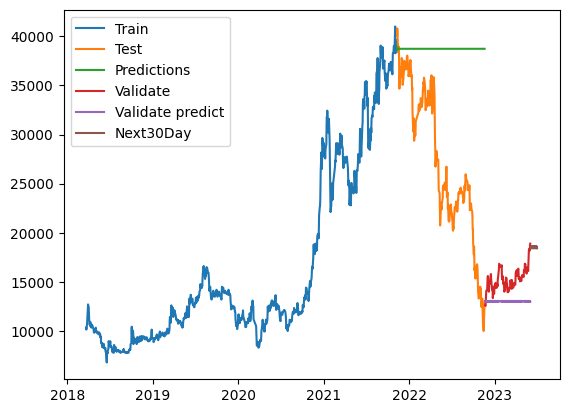

In [15]:
# 9.Vẽ hình
plt.plot(Y_train.index, Y_train)
plt.plot(Y_test.index, Y_test)
plt.plot(Y_test.index, Y_pred)
plt.plot(Y_val.index, Y_val)
plt.plot(Y_val.index, Y_pred_val)
plt.plot(forecast_df['Date'], forecast_df['Close'])
plt.legend(['Train', 'Test', 'Predictions','Validate','Validate predict','Next30Day'])
plt.show()

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names

c:\Users\minhh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



         Date         Close
0  2023-06-03  18197.833333
1  2023-06-04  18577.666667
2  2023-06-05  18227.333333
3  2023-06-06  18577.666667
4  2023-06-07  18227.333333
5  2023-06-08  18577.666667
6  2023-06-09  18227.333333
7  2023-06-10  18577.666667
8  2023-06-11  18227.333333
9  2023-06-12  18577.666667
10 2023-06-13  18227.333333
11 2023-06-14  18577.666667
12 2023-06-15  18227.333333
13 2023-06-16  18577.666667
14 2023-06-17  18227.333333
15 2023-06-18  18577.666667
16 2023-06-19  18227.333333
17 2023-06-20  18577.666667
18 2023-06-21  18227.333333
19 2023-06-22  18577.666667
20 2023-06-23  18227.333333
21 2023-06-24  18577.666667
22 2023-06-25  18227.333333
23 2023-06-26  18577.666667
24 2023-06-27  18227.333333
25 2023-06-28  18577.666667
26 2023-06-29  18227.333333
27 2023-06-30  18577.666667
28 2023-07-01  18227.333333
29        NaT  18577.666667


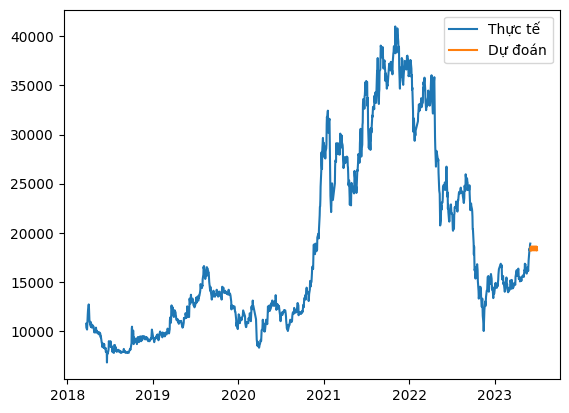

In [16]:

# Xây dựng lại mô hình trên toàn bộ dữ liệu
knn_model = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_model.fit(X, Y)

# Dự đoán giá đóng cửa của 30 ngày tiếp theo
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])
last_price = df['Price'].iloc[-1]
for i in range(30):
    pred = knn_model.predict([[last_price]])
    if len(pred) != 1:
        print("Error: Invalid prediction shape.")
        break
    forecast_df.at[i, 'Close'] = pred[0]
    last_price = pred[0]

# In kết quả dự đoán
print(forecast_df)

# Vẽ biểu đồ dự đoán
plt.plot(df.index, df['Price'], label='Thực tế')
plt.plot(forecast_df['Date'], forecast_df['Close'], label='Dự đoán')
plt.legend()
plt.show()